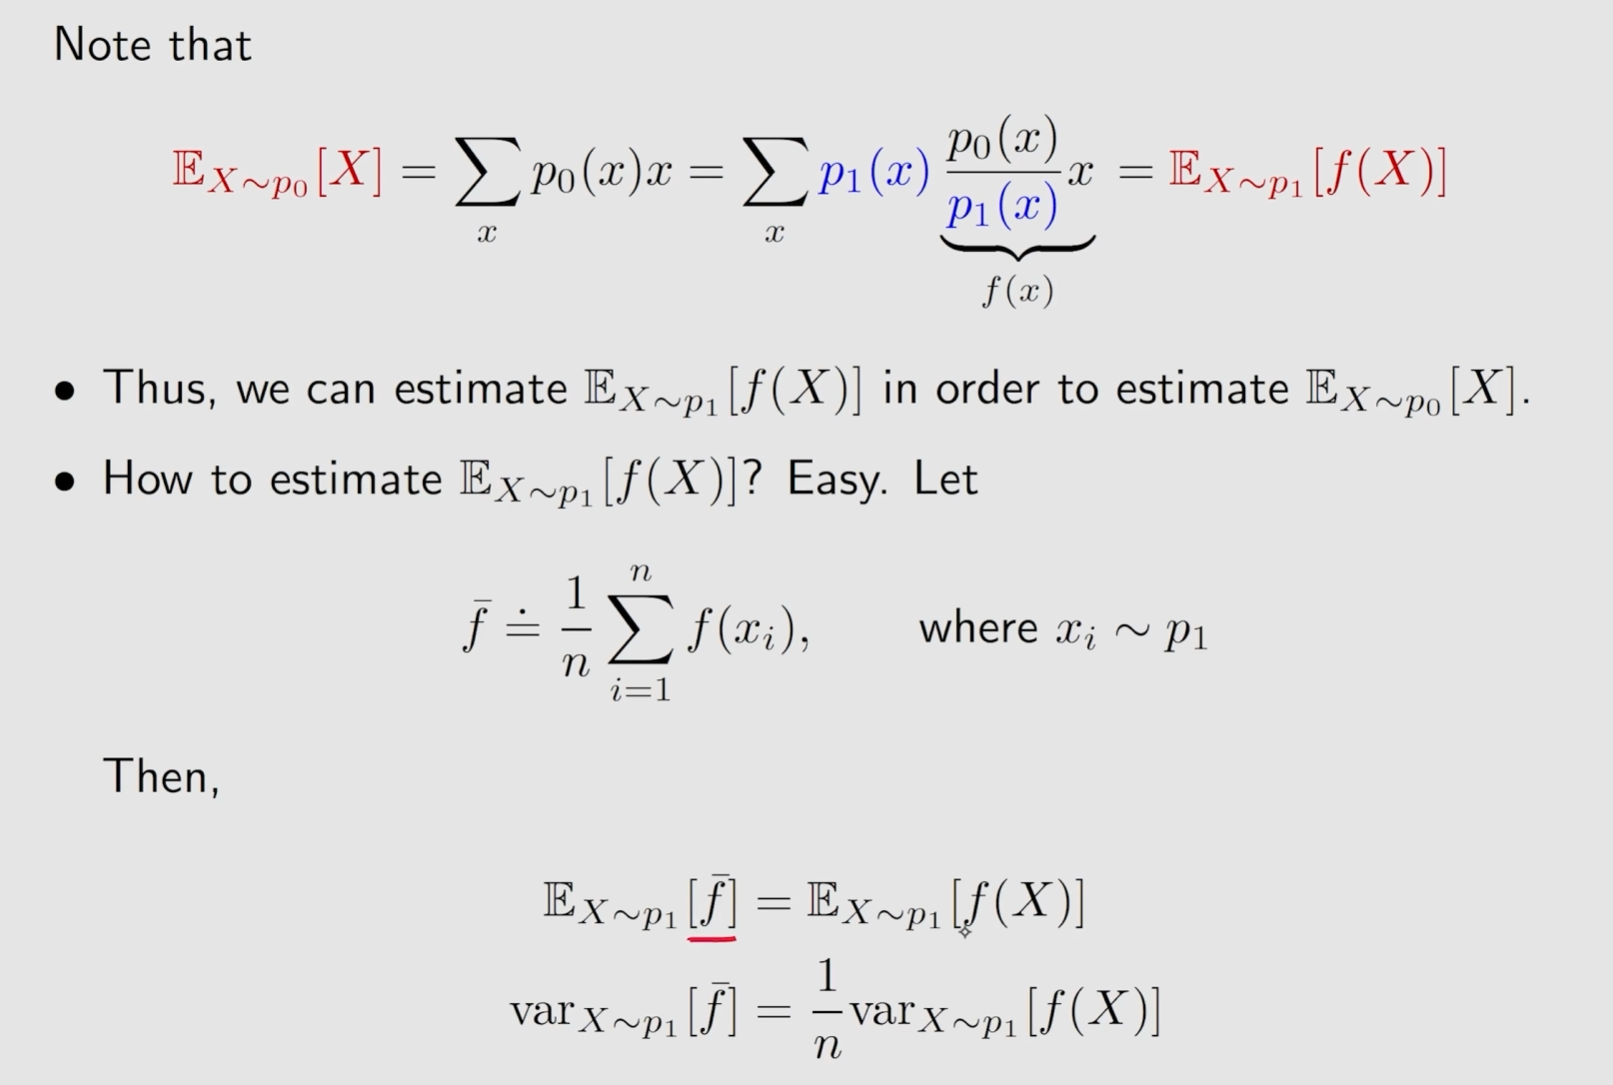

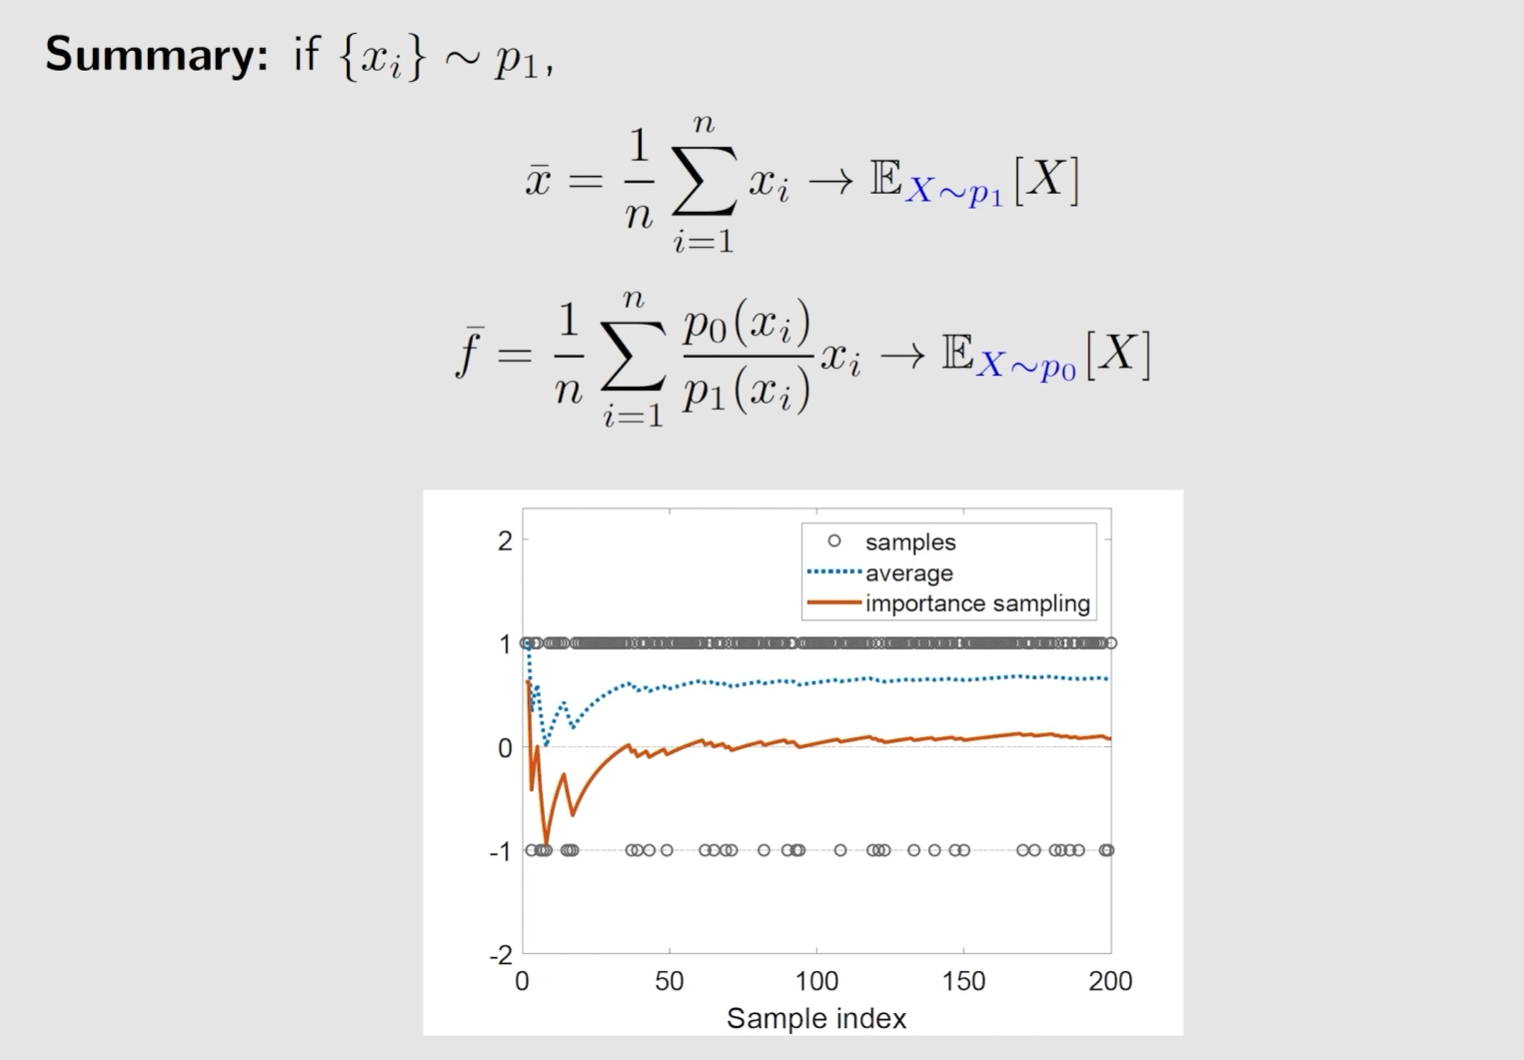

## 什么情况下会用到importance sampling?  
- 明明我都知道了xi 和 p(xi)，为什么不直接用 Σ p(xi) * xi 来计算呢？使用场景是什么？  
当X是一个连续变量，要求它的期望是要求知道P(X)的表达式的，进而计算积分求得期望。但是P(X)是通过神经网络来计算的，无法知道其表达式，而我知道另外这时候就用importance sampling来计算。  
## 为什么不用P(X)生成数据，然后求平均值呢？  
因为P(X)是动态更新的，每更新一次就生成一堆数据费时费力。所以要有一个不变的概率分布Q来生成一堆数据，通过importance sampling计算P的期望。

In [370]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [371]:
value = [-1, 1]
p0 = [0.2, 0.8]
p1 = [0.5, 0.5]
# 0.6
E_p0 = -1 * p0[0] + 1 * p0[1]
# 0.0
E_p1 = -1 * p1[0] + 1 * p1[1]

def fx(p0, p1, xi):
    idx = 0 if xi == -1 else 1
    return p0[idx] * xi / p1[idx]

n = 100000
X = np.random.choice(a=value, p=p1, size=(n, ))

f_xi = np.asarray([fx(p0, p1, xi) for xi in X])
f_bar = f_xi.mean()
print(E_p0)
print(f_bar)

0.6000000000000001
0.5950199999999997


In [372]:
"""
近似一个简单神经网络的分布P
target policy: P
behavior policy: Q
n_actions = 5
"""
class Net(nn.Module):
    def __init__(self, n_actions, hidden_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(n_actions, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions),
            nn.Softmax(-1)
        )

    def forward(self, x):
        all_actions_prob = self.seq(x)
        return all_actions_prob

class Distribution:
    def __init__(self, a, prob):
        self.A = a
        self.p = prob
        pass

    def __call__(self, xi):
        idx = np.vectorize(self.A.index)(xi)
        return self.p[idx]

def calculate_f_bar(P, Q, X):
    fx =  P(X) * X / Q(X)
    return fx.mean()

n_actions = 5
# 采样空间
A = np.arange(1, n_actions+1).tolist()

# target policy: P
model = Net(n_actions=n_actions, hidden_size=16)
prob_p = model(torch.tensor([A], dtype=torch.float)).squeeze().detach().numpy()
# prob_p = np.asarray([0.2, 0.2, 0.2, 0.2, 0.2])
P = Distribution(A, prob_p)
# behavior policy: Q
prob_q = np.array([0.05, 0.25, 0.17, 0.5, 0.03])
Q = Distribution(A, prob_q)


# 基于Q分布生成的数据
X = np.random.choice(a=A, p=prob_q, size=(200000, ))
# Expectation of P
E_P = (P(A)*A).sum()
# Expectation of Q
f_bar = calculate_f_bar(P, Q, X)
E_P,f_bar

(3.691796649247408, 3.6968055040356087)

# Off Policy 


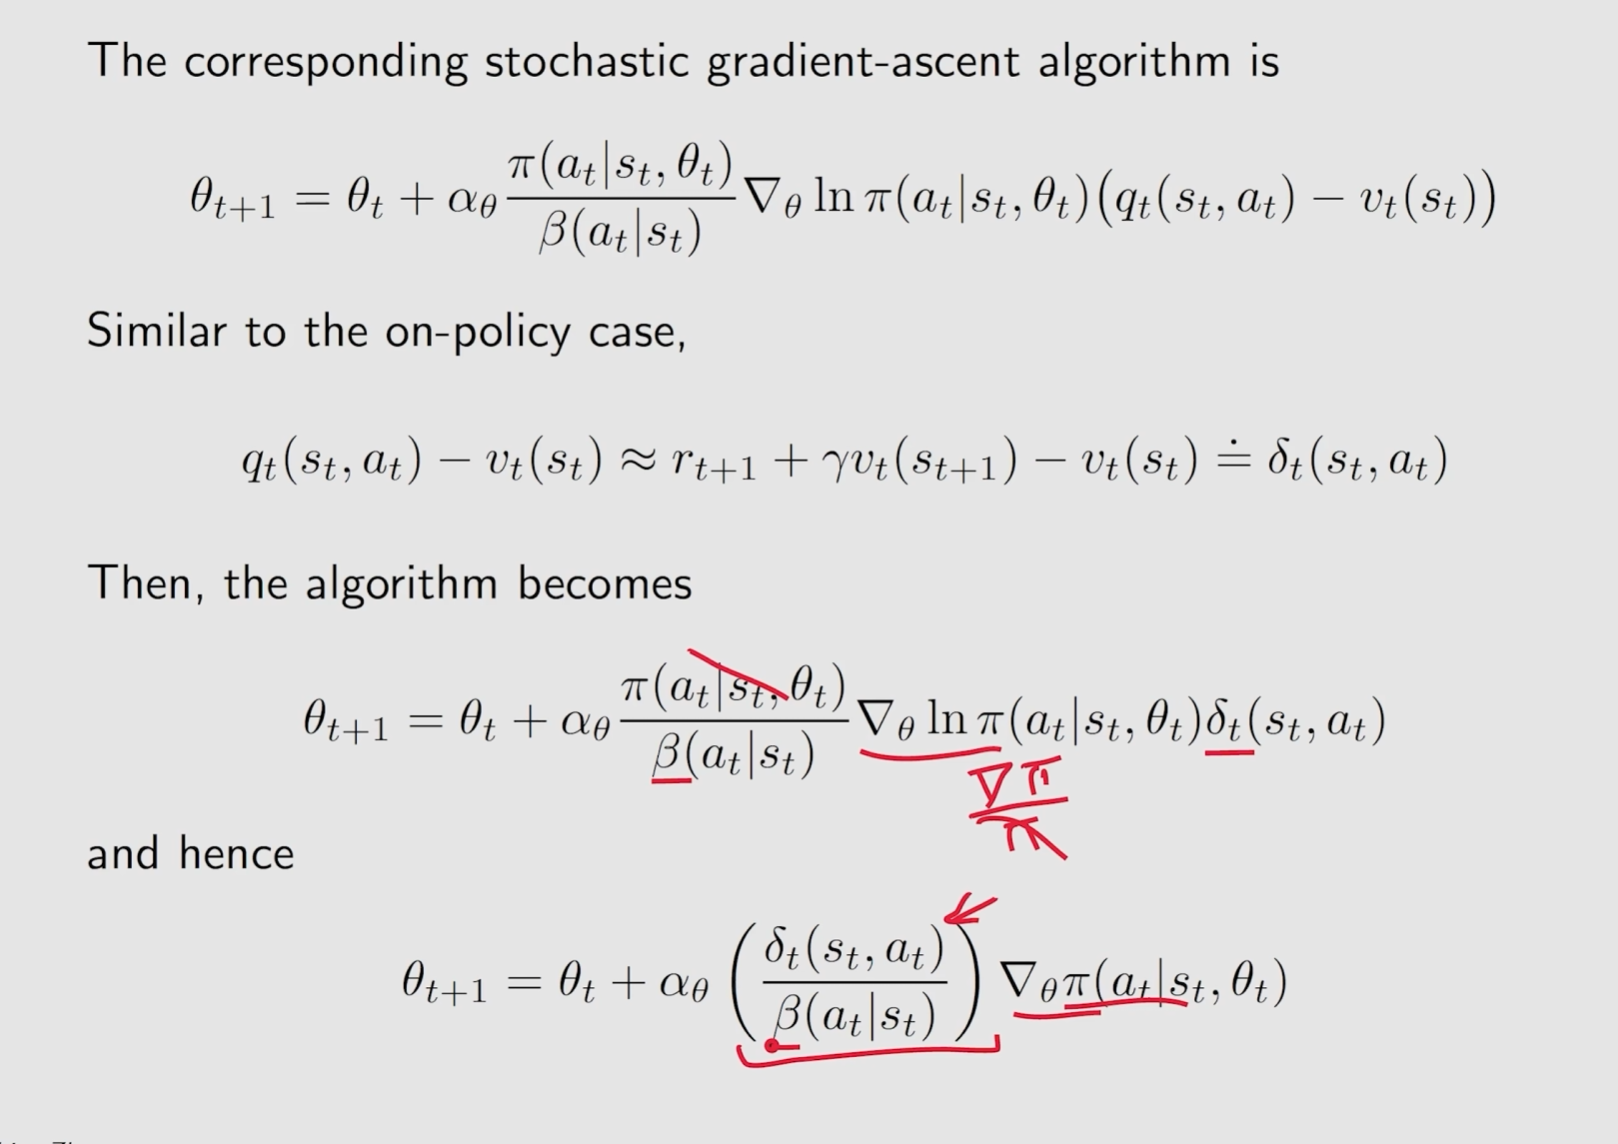

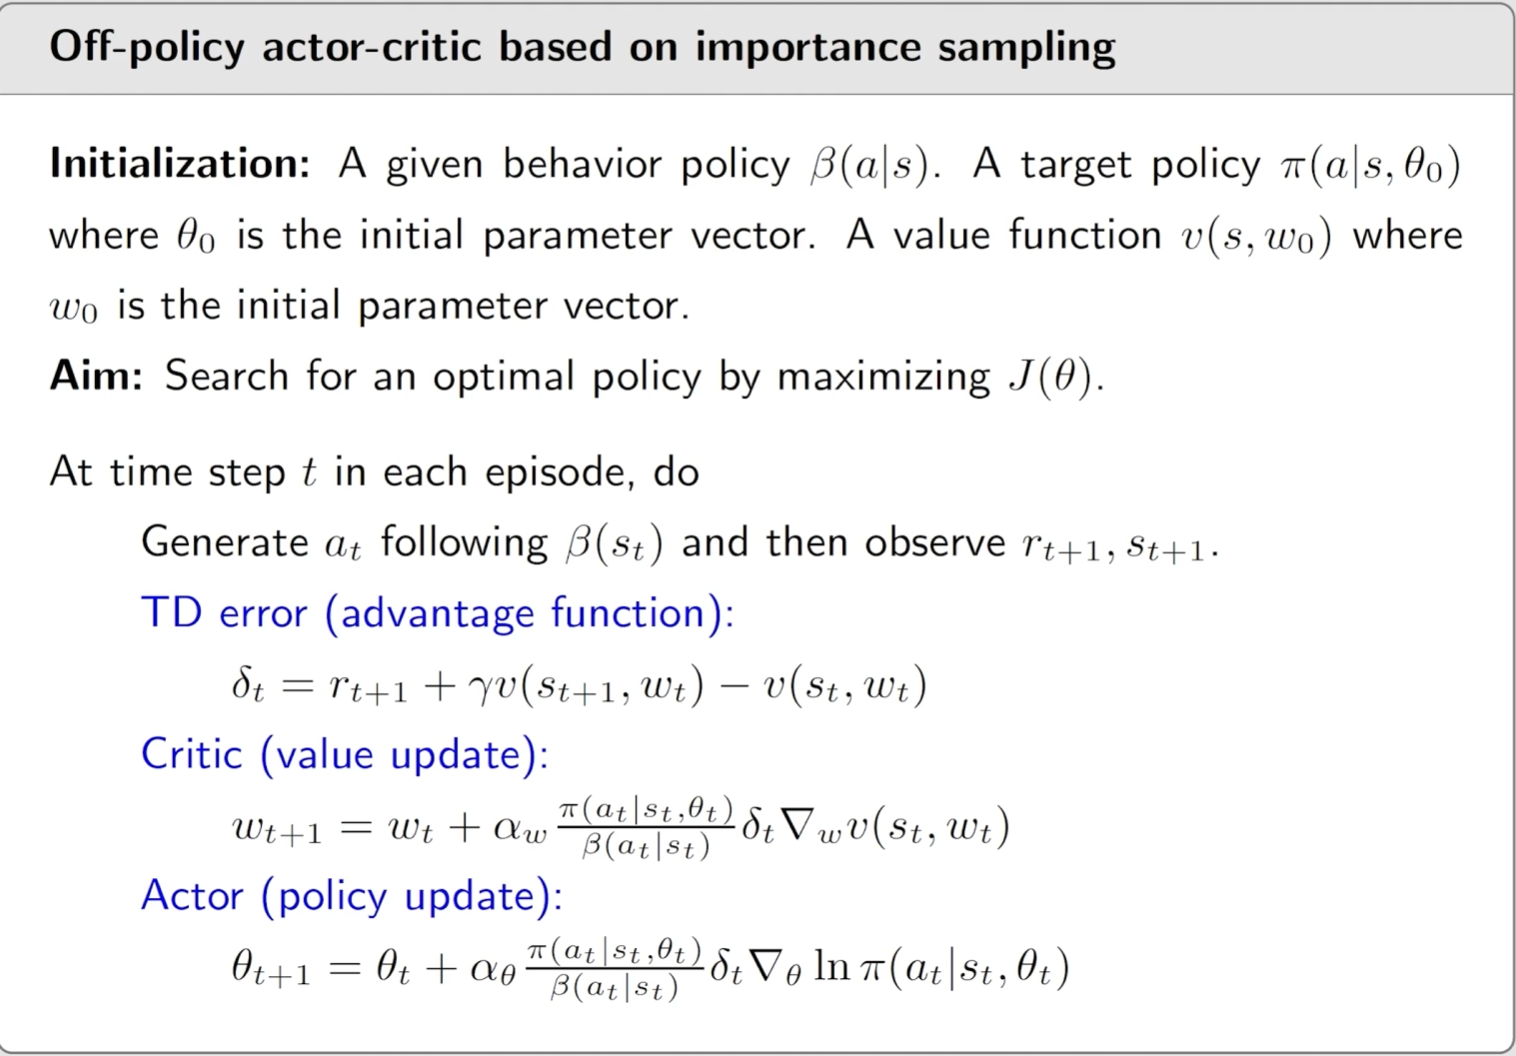

### 先看advantage function部分的(q - v)  
- policy就是在state下做出action的概率。
- q是在s状态下做了一个动作之后，继续根据policy pi得到的return期望  
- v是在s状态下无论做什么动作，继续根据policy pi得到的return期望  
把policy pi 比作好班级， v是好班级的平均得分，根据这个pi做出的action得到的q是好班级一个人的平均得分，这个人的动作好不好是和好班级平均得分作比较，比平均更好，就增大这个action的概率。  
### 再看importance sampling部分  
- beta比作差班级。  
差班级和好班级做同一件事情，好班级在某个state做出的action的概率肯定和差班级不一样，导致得到的分数期望肯定不一样。  
那么在某个state做出某个action，即state-action pair，好班级和差班级在这个state做出这个action概率做一个比较，看看差了多少。   
但是算法是off policy的，差班级不会更新，那么就根据差班级和好班级概率p(s,a)的差距做出一个适应器，差班级每在state做出action的概率经过适应器的转换后能够更接近好班级的概率。    
比较后如果发现，好班级几乎不可能在这个state做出这个action，而差班级却有很大可能，那么适应器就大幅减少差班级做出这个action的倾向。 
### 公式的直观解释  
好班级是动态进步的，好班级会根据更优秀的动作来更新这个动作的概率。  
通常是让好班级做出aciton的概率，再根据相对分数期望，更新参数来优化好班级的action概率。  
但是现在是off policy的，有一个差班级，只能差班级做出action，通过差班级做出action的概率经过适应器逼近好班级的概率来更新参数，进而优化好班级的action概率。  
- 为什么不直接用好班级做出action来优化好班级的actio概率呢，非要间接性通过差班级来优化好班级action概率吗？(问题同为什么不用on policy?)  
因为好班级是动态更新的，上一状态做出的acton只能优化上一状态的policy。  
要想优化这个状态的policy，就需要这个状态重新生成一个新的aciton来评估好坏，进而优化这个状态的policy。  
而这种做法很费时费力。